In [1]:
import pyspark
import os
import json
import argparse
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from pathlib import Path
from pyspark.sql.types import StructType
from pyspark.sql.functions import to_timestamp,col,when

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

## Initialization

In [3]:
dotenv_path = Path('/resources/.env')
load_dotenv(dotenv_path=dotenv_path)
print(f"Loaded .env file: {os.environ}")

Loaded .env file: environ({'SHELL': '/bin/bash', 'HOSTNAME': '402bdc7229c3', 'LANGUAGE': 'en_US.UTF-8', 'SPARK_OPTS': '--driver-java-options=-Xms1024M --driver-java-options=-Xmx4096M --driver-java-options=-Dlog4j.logLevel=info', 'NB_UID': '1000', 'JUPYTER_ALLOW_INSECURE_WRITES': '1', 'PWD': '/home/jovyan', 'HOME': '/home/jovyan', 'LANG': 'en_US.UTF-8', 'NB_GID': '100', 'XDG_CACHE_HOME': '/home/jovyan/.cache', 'APACHE_SPARK_VERSION': '3.3.2', 'HADOOP_VERSION': '3', 'SHLVL': '0', 'CONDA_DIR': '/opt/conda', 'SPARK_HOME': '/usr/local/spark', 'JUPYTER_PORT': '8888', 'SPARK_CONF_DIR': '/usr/local/spark/conf', 'NB_USER': 'jovyan', 'LC_ALL': 'en_US.UTF-8', 'PATH': '/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/spark/bin', 'PYSPARK_PYTHONPATH_SET': '1', 'DEBIAN_FRONTEND': 'noninteractive', 'LOGNAME': 'jovyan', 'USER': 'jovyan', 'TERM': 'xterm-color', 'SUDO_COMMAND': '/opt/conda/bin/jupyter lab', 'SUDO_USER': 'root', 'SUDO_UID': '0', 'SUDO_GID': '0', 'PYT

In [4]:
postgres_host = os.getenv('DIBIMBING_DE_POSTGRES_HOST')
postgres_db = os.getenv('DIBIMBING_DE_POSTGRES_DB')
postgres_user = os.getenv('DIBIMBING_DE_POSTGRES_ACCOUNT')
postgres_password = os.getenv('DIBIMBING_DE_POSTGRES_PASSWORD')

In [5]:
sparkcontext = pyspark.SparkContext.getOrCreate(conf=(
        pyspark
        .SparkConf()
        .setAppName('Dibimbing')
        .setMaster('local')
        .set("spark.jars", "/opt/postgresql-42.2.18.jar")
    ))
sparkcontext.setLogLevel("WARN")

spark = pyspark.sql.SparkSession(sparkcontext.getOrCreate())

In [6]:
spark

## JDBC

In [7]:
jdbc_url = f'jdbc:postgresql://{postgres_host}/{postgres_db}'
jdbc_properties = {
    'user': postgres_user,
    'password': postgres_password,
    'driver': 'org.postgresql.Driver',
    'stringtype': 'unspecified'
}

In [8]:
retail_df = spark.read.jdbc(
    jdbc_url,
    'public.retail',
    properties=jdbc_properties
)
retail_df.show(10)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6| 2010-12-01|     4.25|     17850|United Kingdom|


In [9]:
print("Number of rows: {}".format(retail_df.count()))
print("Number of columns: {}".format(len(retail_df.columns)))

Number of rows: 541909
Number of columns: 8


In [10]:
# Count the number of duplicates in the dataset
# Find duplicate rows
duplicate_rows = retail_df.groupBy(col("invoiceno"), col("stockcode"), col("description"), col("quantity"), col("invoicedate"), col("unitprice"), col("customerid"), col("country")).count().filter(col("count") > 1)

# Show duplicate rows and their duplicates
duplicate_rows.show()
duplicate_count = retail_df.count() - retail_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")
retail_df = retail_df.dropDuplicates()
print(f"Duplicates removed")

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|count|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   536551|    22551|PLASTERS IN TIN S...|       1| 2010-12-01|     1.65|     17346|United Kingdom|    2|
|   537769|    22834|HAND WARMER BABUS...|       1| 2010-12-08|      2.1|     15021|United Kingdom|    2|
|   538201|    22652|   TRAVEL SEWING KIT|       1| 2010-12-10|     1.65|     15723|United Kingdom|    2|
|   541855|    22465|HANGING METAL STA...|       1| 2011-01-23|     1.65|     13742|United Kingdom|    2|
|   542112|    85150|LADIES & GENTLEME...|       1| 2011-01-25|     2.55|     13168|United Kingdom|    2|
|   544463|    22256|FELT FARM ANIMAL ...|       1| 2011-02-20|     1.25|     12988|United Kingdom|    4|
|   546731|   15044A| PINK PAPER PARASOL |    

In [11]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
# from pyspark.sql.functions import col, isnan, isnull

# Count the number of missing values in each column
missing_counts = retail_df.select([col(c).isNull().cast("int").alias(c) for c in retail_df.columns]) \
                         .agg(*[sum(col(c)).alias(c) for c in retail_df.columns])

# Display the missing value counts
missing_counts.show()

# Remove rows with missing values
retail_df = retail_df.filter(col("customerid").isNotNull())
retail_df = retail_df.withColumn("description", when(col("description").isNull(), "Others").otherwise(col("description")))

# Get the number of rows
num_rows = retail_df.count()

# Get the number of columns
num_cols = len(retail_df.columns)

# Print the shape of the DataFrame
print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_cols))
print(f"Removed empty values from customerid")
print(f"Imputed empty descriptions with 'Others'")

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135037|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+

Number of rows: 401603
Number of columns: 8
Removed empty values from customerid
Imputed empty descriptions with 'Others'


In [12]:
# Iterate over each column
for column in retail_df.columns:
    distinct_count = retail_df.select(column).distinct().count()
    distinct_values = retail_df.select(column).distinct().limit(5).collect()
    values_list = [str(row[column]) for row in distinct_values]
    print(f"Number of distinct values for column '{column}': {distinct_count}")
    print(f"Distinct values for column '{column}':")
    print(", ".join(values_list))
    print()

Number of distinct values for column 'invoiceno': 22190
Distinct values for column 'invoiceno':
536938, 537691, 538184, 538517, 538879

Number of distinct values for column 'stockcode': 3684
Distinct values for column 'stockcode':
22728, 21889, 90210B, 21259, 21894

Number of distinct values for column 'description': 3896
Distinct values for column 'description':
10 COLOUR SPACEBOY PEN, SET/10 BLUE POLKADOT PARTY CANDLES, POTTING SHED SOW 'N' GROW SET, SET/3 RED GINGHAM ROSE STORAGE BOX, MAGNETS PACK OF 4 VINTAGE LABELS 

Number of distinct values for column 'quantity': 436
Distinct values for column 'quantity':
496, -35, 392, 540, 31

Number of distinct values for column 'invoicedate': 305
Distinct values for column 'invoicedate':
2011-01-30, 2011-05-06, 2011-10-07, 2011-01-23, 2011-07-07

Number of distinct values for column 'unitprice': 620
Distinct values for column 'unitprice':
10.65, 0.66, 206.4, 9.13, 3.26

Number of distinct values for column 'customerid': 4372
Distinct values 

In [13]:
summary_df = retail_df.describe().toPandas()
print(summary_df)

  summary          invoiceno           stockcode   
0   count             401603              401603  \
1    mean  560591.0556513236  27434.089987318876   
2  stddev  13087.12918128383   16408.23213416858   
3     min             536365               10002   
4     max            C581569                POST   

                        description            quantity           unitprice   
0                            401603              401603              401603  \
1                              None  12.183297933531373  3.4740674347487133   
2                              None  250.28334823423202   69.76412187978318   
3     4 PURPLE FLOCK DINNER CANDLES              -80995                 0.0   
4  ZINC WIRE SWEETHEART LETTER TRAY               80995             38970.0   

           customerid      country  
0              401603       401603  
1  15281.162092912653         None  
2  1714.0080320144905         None  
3               12346    Australia  
4               18287  Unsp

In [14]:
# Generate summary statistics using describe()
summary_df = retail_df.describe()

# Show the summary statistics
summary_df.show()

+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|summary|        invoiceno|         stockcode|         description|          quantity|         unitprice|        customerid|    country|
+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|  count|           401603|            401603|              401603|            401603|            401603|            401603|     401603|
|   mean|560591.0556513236|27434.089987318876|                null|12.183297933531373|3.4740674347487133|15281.162092912653|       null|
| stddev|13087.12918128383| 16408.23213416858|                null|250.28334823423202| 69.76412187978318|1714.0080320144905|       null|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|            -80995|               0.0|             12346|  Australia|
|    max|          C581569|              

In [15]:
# Check for negative quantities and get count
negative_quantities = retail_df.filter(col("quantity") < 0)
negative_quantities_count = negative_quantities.count()
print("Count of negative quantities:", negative_quantities_count)

# Check for unusually high prices and get count
high_prices = retail_df.filter(col("unitprice") > 1000)
high_prices_count = high_prices.count()
print("Count of prices greater than 1000:", high_prices_count)

Count of negative quantities: 8872
Count of prices greater than 1000: 46


In [16]:
from pyspark.sql.functions import col

filtered_retail_df = retail_df.filter((col("customerid") == 14911) & (col("stockcode") == "21155"))
filtered_retail_df.show()

+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|country|
+---------+---------+--------------------+--------+-----------+---------+----------+-------+
|  C539576|    21155|RED RETROSPOT PEG...|     -12| 2010-12-20|      2.1|     14911|   EIRE|
|   539320|    21155|RED RETROSPOT PEG...|      12| 2010-12-16|      2.1|     14911|   EIRE|
|   581433|    21155|RED RETROSPOT PEG...|       6| 2011-12-08|     2.55|     14911|   EIRE|
|   538009|    21155|RED RETROSPOT PEG...|       6| 2010-12-09|      2.1|     14911|   EIRE|
|   548449|    21155|RED RETROSPOT PEG...|       6| 2011-03-31|     2.55|     14911|   EIRE|
|   570016|    21155|RED RETROSPOT PEG...|       6| 2011-10-07|     2.55|     14911|   EIRE|
|   568048|    21155|RED RETROSPOT PEG...|       6| 2011-09-23|     2.55|     14911|   EIRE|
|   565800|    21155|RED RETROSPOT PEG...|       6| 2011-09-07|     2.

In [17]:
filtered_retail_df = retail_df.filter((col("unitprice") > 1000))
filtered_retail_df.show()

+---------+---------+---------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|    description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+---------------+--------+-----------+---------+----------+--------------+
|  C560647|        M|         Manual|      -1| 2011-07-20|   3060.6|     18102|United Kingdom|
|  C548830|        M|         Manual|      -1| 2011-04-04|  2382.92|     12744|     Singapore|
|  C542348|        M|         Manual|      -1| 2011-01-27|  1715.85|     12539|         Spain|
|  C571750|        M|         Manual|      -1| 2011-10-19|  2118.74|     12744|     Singapore|
|  C562647|        M|         Manual|      -1| 2011-08-08|  3155.95|     15502|United Kingdom|
|  C551685|     POST|        POSTAGE|      -1| 2011-05-03|  8142.75|     16029|United Kingdom|
|   548820|        M|         Manual|       1| 2011-04-04|  2053.07|     12744|     Singapore|
|   579196|      DOT| DOTCOM POSTAGE|       1| 201

In [18]:
# Convert transaction date to a proper date type
retail_df = retail_df.withColumn("invoicedate", to_date("invoicedate", "yyyy-MM-dd"))
max_invoice_date = retail_df.agg({"invoicedate": "max"}).collect()[0][0]

# Calculate recency, frequency, and monetary value for each customer
rfm = retail_df.groupBy("customerid") \
    .agg(
        datediff(lit(max_invoice_date), max("invoicedate")).alias("recency"),
        countDistinct("invoiceno").alias("frequency"),
        (sum(col("unitprice") * col("quantity"))).alias("monetary_value")
    )

# Calculate quartiles and assign scores for recency, frequency, and monetary value
recency_quantiles = rfm.approxQuantile("recency", [0.25, 0.5, 0.75], 0.05)
frequency_quantiles = rfm.approxQuantile("frequency", [0.25, 0.5, 0.75], 0.05)
monetary_quantiles = rfm.approxQuantile("monetary_value", [0.25, 0.5, 0.75], 0.05)

rfm = rfm.withColumn("recency_score",
                     when(col("recency") <= recency_quantiles[0], 5)
                     .when((col("recency") > recency_quantiles[0]) & (col("recency") <= recency_quantiles[1]), 4)
                     .when((col("recency") > recency_quantiles[1]) & (col("recency") <= recency_quantiles[2]), 3)
                     .otherwise(2))

rfm = rfm.withColumn("frequency_score",
                     when(col("frequency") <= frequency_quantiles[0], 2)
                     .when((col("frequency") > frequency_quantiles[0]) & (col("frequency") <= frequency_quantiles[1]), 3)
                     .when((col("frequency") > frequency_quantiles[1]) & (col("frequency") <= frequency_quantiles[2]), 4)
                     .otherwise(5))

rfm = rfm.withColumn("monetary_score",
                     when(col("monetary_value") <= monetary_quantiles[0], 2)
                     .when((col("monetary_value") > monetary_quantiles[0]) & (col("monetary_value") <= monetary_quantiles[1]), 3)
                     .when((col("monetary_value") > monetary_quantiles[1]) & (col("monetary_value") <= monetary_quantiles[2]), 4)
                     .otherwise(5))

# Calculate overall RFM score and segment customers based on RFM score
rfm = rfm.withColumn("rfm_score", (col("recency_score") + col("frequency_score") + col("monetary_score")) / 3)
rfm_quantiles = rfm.approxQuantile("rfm_score", [0.25, 0.5, 0.75], 0.05)
rfm = rfm.withColumn("rfm_segment",
                     when(col("rfm_score") >= rfm_quantiles[2], "Champions")
                     .when(col("rfm_score") >= rfm_quantiles[1], "Loyal Customers")
                     .when(col("rfm_score") >= rfm_quantiles[0], "Potential Loyalists")
                     .otherwise("Lost Customers"))

# Print the results
rfm.show()

+----------+-------+---------+------------------+-------------+---------------+--------------+------------------+-------------------+
|customerid|recency|frequency|    monetary_value|recency_score|frequency_score|monetary_score|         rfm_score|        rfm_segment|
+----------+-------+---------+------------------+-------------+---------------+--------------+------------------+-------------------+
|     15555|     12|       20|           4747.89|            5|              5|             5|               5.0|          Champions|
|     15574|    177|        4| 675.6399999999999|            2|              4|             4|3.3333333333333335|    Loyal Customers|
|     15634|     17|        1|243.54999999999995|            5|              2|             2|               3.0|Potential Loyalists|
|     13610|     12|        9|           1065.88|            5|              5|             4| 4.666666666666667|          Champions|
|     13192|     95|        2|            911.94|            3

In [19]:
print("Recency Range:")
rfm.select(min("recency"), max("recency")).show()

print("Frequency Range:")
rfm.select(min("frequency"), max("frequency")).show()

print("Monetary Value Range:")
rfm.select(min("monetary_value"), max("monetary_value")).show()

Recency Range:
+------------+------------+
|min(recency)|max(recency)|
+------------+------------+
|           0|         373|
+------------+------------+

Frequency Range:
+--------------+--------------+
|min(frequency)|max(frequency)|
+--------------+--------------+
|             1|           248|
+--------------+--------------+

Monetary Value Range:
+-------------------+-------------------+
|min(monetary_value)|max(monetary_value)|
+-------------------+-------------------+
|           -4287.63|  279489.0200000002|
+-------------------+-------------------+



In [20]:
# Get the range of values for the 'recency', 'frequency', and 'monetary_value' columns
range_values = rfm.agg(
    min("recency").alias("min_recency"),
    max("recency").alias("max_recency"),
    min("frequency").alias("min_frequency"),
    max("frequency").alias("max_frequency"),
    min("monetary_value").alias("min_monetary_value"),
    max("monetary_value").alias("max_monetary_value")
).collect()[0]

# Access the range values
min_recency = range_values["min_recency"]
max_recency = range_values["max_recency"]
min_frequency = range_values["min_frequency"]
max_frequency = range_values["max_frequency"]
min_monetary_value = range_values["min_monetary_value"]
max_monetary_value = range_values["max_monetary_value"]

# Print the range values
print("Recency Range: {} - {}".format(min_recency, max_recency))
print("Frequency Range: {} - {}".format(min_frequency, max_frequency))
print("Monetary Value Range: {} - {}".format(min_monetary_value, max_monetary_value))


Recency Range: 0 - 373
Frequency Range: 1 - 248
Monetary Value Range: -4287.63 - 279489.01999999996


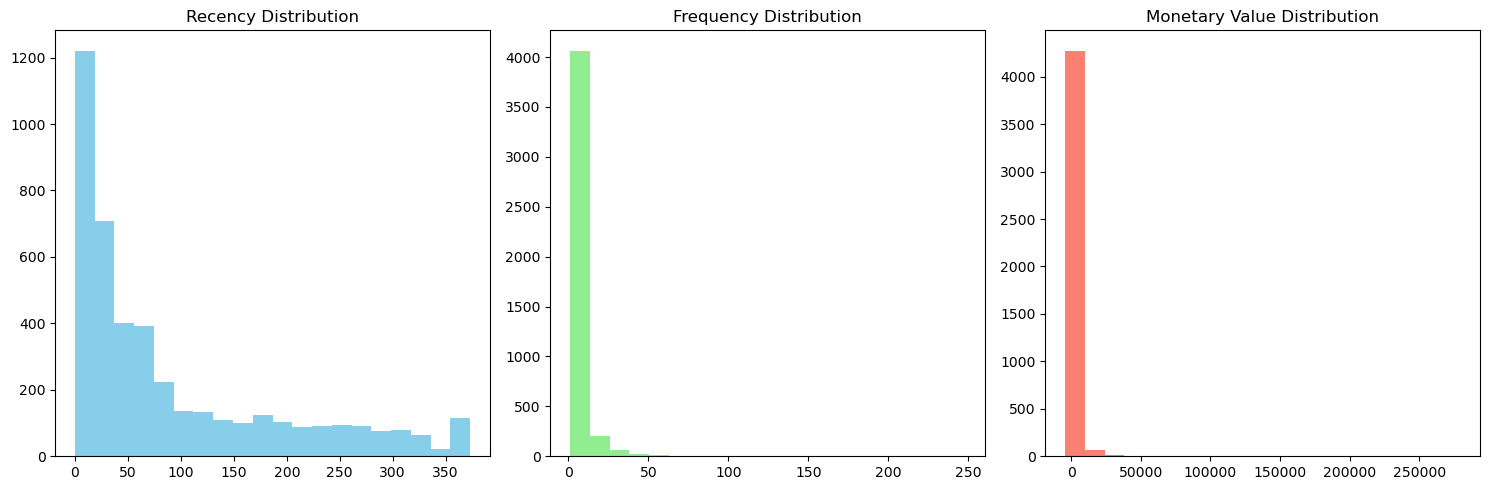

Distribusi Customer RFM Segment
+-------------------+-----+
|        rfm_segment|count|
+-------------------+-----+
|          Champions| 1252|
|     Lost Customers|  930|
|    Loyal Customers| 1194|
|Potential Loyalists|  996|
+-------------------+-----+



In [21]:
# Calculate the count per RFM segment
segment_counts = rfm.groupBy("rfm_segment").count().orderBy("rfm_segment")

# Visualize the distribution of values
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of 'recency'
axes[0].hist(rfm.select("recency").rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue')
axes[0].set_title("Recency Distribution")

# Plot the distribution of 'frequency'
axes[1].hist(rfm.select("frequency").rdd.flatMap(lambda x: x).collect(), bins=20, color='lightgreen')
axes[1].set_title("Frequency Distribution")

# Plot the distribution of 'monetary_value'
axes[2].hist(rfm.select("monetary_value").rdd.flatMap(lambda x: x).collect(), bins=20, color='salmon')
axes[2].set_title("Monetary Value Distribution")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Print the count per RFM segment
print(f"Distribusi Customer RFM Segment")
segment_counts.show()


In [22]:
summary_df = rfm.groupBy("rfm_segment").agg(
    round(avg("recency"), 1).alias("Rata-rata Recency (Hari sejak transaksi) Customers"),
    round(avg("frequency"), 1).alias("Rata-rata Frekuensi Transaksi Customers"),
    round(avg("monetary_value"), 1).alias("Rata-rata Total Spending Customers")
)

print("Behavior RFM Segment (Average)")
summary_df.show()

Behavior RFM Segment (Average)
+-------------------+--------------------------------------------------+---------------------------------------+----------------------------------+
|        rfm_segment|Rata-rata Recency (Hari sejak transaksi) Customers|Rata-rata Frekuensi Transaksi Customers|Rata-rata Total Spending Customers|
+-------------------+--------------------------------------------------+---------------------------------------+----------------------------------+
|          Champions|                                              18.3|                                   12.1|                            5120.1|
|Potential Loyalists|                                             106.2|                                    1.8|                             448.9|
|    Loyal Customers|                                              54.9|                                    3.4|                            1037.0|
|     Lost Customers|                                             221.6|         

In [23]:
# from pyspark.sql.functions import col, expr

# # Create window specifications for partitioning by rfm_segment
# window_spec = Window.partitionBy("rfm_segment")

# Calculate median for recency, frequency, and monetary_value
summary_df = rfm.groupBy("rfm_segment").agg(
    expr("percentile_approx(recency, 0.5)").alias("Median Recency (Hari sejak transaksi) Customers"),
    expr("percentile_approx(frequency, 0.5)").alias("Median Frekuensi Transaksi Customers"),
    round(expr("percentile_approx(monetary_value, 0.5)"),1).alias("Median Total Spending Customers")
)

# Display the summary DataFrame
print("Behavior RFM Segment (Median)")
summary_df.show()


Behavior RFM Segment (Median)
+-------------------+-----------------------------------------------+------------------------------------+-------------------------------+
|        rfm_segment|Median Recency (Hari sejak transaksi) Customers|Median Frekuensi Transaksi Customers|Median Total Spending Customers|
+-------------------+-----------------------------------------------+------------------------------------+-------------------------------+
|          Champions|                                             11|                                   8|                         2456.8|
|Potential Loyalists|                                             74|                                   2|                          379.5|
|    Loyal Customers|                                             36|                                   3|                          781.3|
|     Lost Customers|                                            227|                                   1|                          187.

In [24]:
summary_df = rfm.groupBy("rfm_segment").agg(
    expr("percentile_approx(recency, 0.5)").alias("Median Recency (Hari sejak transaksi) Customers"),
    expr("percentile_approx(frequency, 0.5)").alias("Median Frekuensi Transaksi Customers"),
    round(expr("percentile_approx(monetary_value, 0.5)"),1).alias("Median Total Spending Customers")
)

# Display the summary DataFrame
print("Behavior RFM Segment (Median)")
summary_df.show()

Behavior RFM Segment (Median)
+-------------------+-----------------------------------------------+------------------------------------+-------------------------------+
|        rfm_segment|Median Recency (Hari sejak transaksi) Customers|Median Frekuensi Transaksi Customers|Median Total Spending Customers|
+-------------------+-----------------------------------------------+------------------------------------+-------------------------------+
|          Champions|                                             11|                                   8|                         2456.8|
|Potential Loyalists|                                             74|                                   2|                          379.5|
|    Loyal Customers|                                             36|                                   3|                          781.3|
|     Lost Customers|                                            227|                                   1|                          187.